In [1]:
!pip -q install wordcloud folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler


plt.rcParams["figure.figsize"] = (12, 5)
sns.set(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})
pd.set_option("display.max_columns", 100)


In [4]:
# Data
URLS = {
    "customers": "/content/olist_customers_dataset.csv",
    "geolocation": "/content/olist_geolocation_dataset.csv",
    "order_items": "/content/olist_order_items_dataset.csv",
    "payments": "/content/olist_order_payments_dataset.csv",
    "reviews": "/content/olist_order_reviews_dataset.csv",
    "orders": "/content/olist_orders_dataset.csv",
    "sellers": "/content/olist_sellers_dataset.csv",
    "products": "/content/olist_products_dataset.csv",
    "product_name_translation": "/content/product_category_name_translation.csv",
}

dfs = {k: pd.read_csv(v) for k, v in URLS.items()}

# Merging Portuguese to English product names
products = dfs["products"].merge(
    dfs["product_name_translation"],
    how="left",
    on="product_category_name"
).drop(columns=["product_category_name"])
dfs["products"] = products

# Shape
overview = []
for name, df in dfs.items():
    overview.append({
        "dataset": name,
        "rows": df.shape[0],
        "cols": df.shape[1],
        "null_values": int(df.isna().sum().sum()),
        "duplicates": int(df.duplicated().sum())
    })
pd.DataFrame(overview).sort_values("dataset").reset_index(drop=True)


,dataset,rows,cols,null_values,duplicates
0,customers,99441,5,0,0
1,geolocation,1000163,5,0,261831
2,order_items,112650,7,0,0
3,orders,99441,8,4908,0
4,payments,103886,5,0,0
5,product_name_translation,71,2,0,0
6,products,32951,9,2461,0
7,reviews,99224,7,145903,0
8,sellers,3095,4,0,0


In [5]:
orders = dfs["orders"].copy()
reviews = dfs["reviews"].copy()
order_items = dfs["order_items"].copy()
payments = dfs["payments"].copy()
customers = dfs["customers"].copy()
sellers = dfs["sellers"].copy()
geolocation = dfs["geolocation"].copy()

# → datetime cast
date_cols_orders = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for c in date_cols_orders:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")

for c in ["review_creation_date","review_answer_timestamp"]:
    reviews[c] = pd.to_datetime(reviews[c], errors="coerce")

order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], errors="coerce")

# remove undefined payment types
payments = payments[~payments["payment_type"].eq("not_defined")].copy()

# Build a monthly order count to detect sparse months, then filter those months out
monthly_counts = (
    orders
    .groupby(orders["order_purchase_timestamp"].dt.to_period("M"))["order_id"]
    .count()
    .rename("n_orders")
    .to_frame()
)
# months with suspiciously low counts we want to remove (per original logic)
bad_months = ["2016-09","2016-10","2016-11","2016-12","2018-09","2018-10"]
bad_order_ids = set(
    orders.loc[
        orders["order_purchase_timestamp"].dt.to_period("M").astype(str).isin(bad_months),
        "order_id"
    ].tolist()
)

def _drop_bad_orders(df, key="order_id"):
    return df[~df[key].isin(bad_order_ids)].copy()

orders      = _drop_bad_orders(orders, "order_id")
order_items = _drop_bad_orders(order_items, "order_id")
payments    = _drop_bad_orders(payments, "order_id")
reviews     = _drop_bad_orders(reviews, "order_id")

# Consolidate geolocation: average lat/lng by ZIP prefix + keep city/state once
geo_avg = (
    geolocation.drop_duplicates()
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
    .mean()
    .reset_index()
)
geo_cs = geolocation[["geolocation_zip_code_prefix","geolocation_city","geolocation_state"]]\
            .drop_duplicates(subset=["geolocation_zip_code_prefix"])
geo = geo_avg.merge(geo_cs, on="geolocation_zip_code_prefix", how="inner")


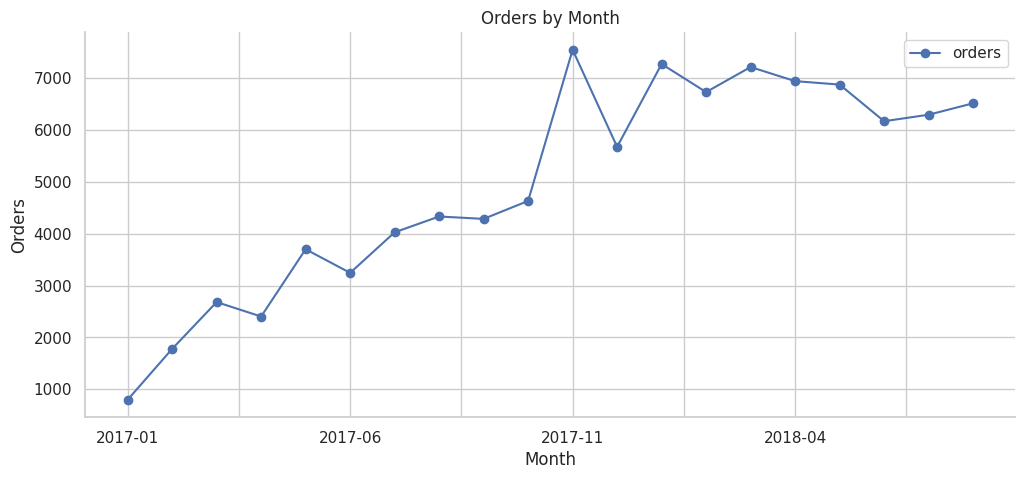

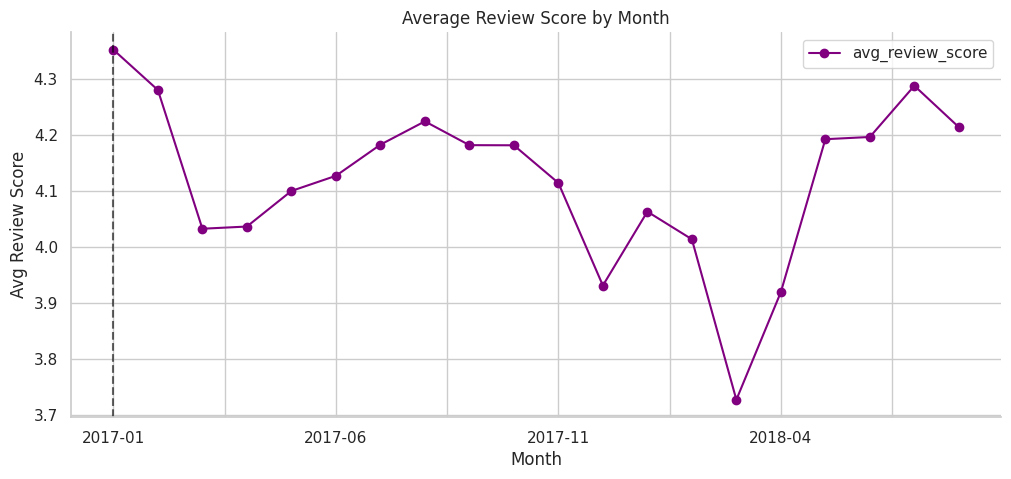

In [6]:
# Orders over time
monthly_orders = (
    orders
    .groupby(orders["order_purchase_timestamp"].dt.to_period("M"))["order_id"]
    .count()
    .rename("orders")
    .to_frame()
)
monthly_orders.index = monthly_orders.index.astype(str)

ax = monthly_orders.plot(kind="line", marker="o", title="Orders by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Orders")
plt.show()

# Average review score over time
monthly_review_score = (
    reviews
    .groupby(reviews["review_creation_date"].dt.to_period("M"))["review_score"]
    .mean()
    .rename("avg_review_score")
    .to_frame()
)
monthly_review_score.index = monthly_review_score.index.astype(str)

ax = monthly_review_score.plot(kind="line", marker="o", color="purple",
                               title="Average Review Score by Month")
ax.axvline("2017-11", color="black", linestyle="--", alpha=0.6)
ax.set_xlabel("Month")
ax.set_ylabel("Avg Review Score")
plt.show()


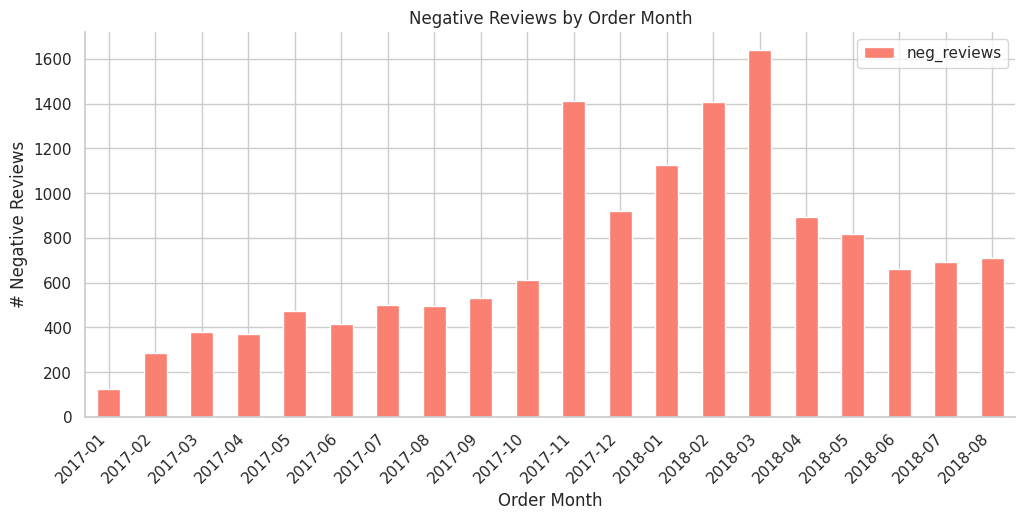

,count
produto,18244
prazo,8386
entrega,6452
antes,5584
chegou,5504
recebi,5238
bom,4585
recomendo,4280
entregue,3737
veio,3264


In [7]:
neg = reviews.loc[reviews["review_score"].isin([1,2])].copy()
neg = neg.merge(orders[["order_id","order_purchase_timestamp"]], on="order_id", how="left")
neg["order_month"] = neg["order_purchase_timestamp"].dt.to_period("M").astype(str)

neg_monthly = neg.groupby("order_month")["review_id"].count().rename("neg_reviews").to_frame()

ax = neg_monthly.plot(kind="bar", color="salmon", title="Negative Reviews by Order Month")
ax.set_xlabel("Order Month")
ax.set_ylabel("# Negative Reviews")
plt.xticks(rotation=45, ha="right")
plt.show()

# Basic Portuguese stopword removal + word frequency
pt_sw = set(stopwords.words("portuguese"))
def clean_pt_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"[\r\n\.,!?\d]+", " ", s)
    tokens = [t for t in s.split() if t not in pt_sw]
    return " ".join(tokens)

neg_text = reviews[["review_comment_message"]].dropna().copy()
neg_text["clean"] = neg_text["review_comment_message"].map(clean_pt_text)

# Word frequencies
word_freq = {}
neg_text["clean"].str.split().dropna().apply(lambda toks: [word_freq.setdefault(t,0) or None for t in toks])
# Increment counts
for toks in neg_text["clean"].str.split():
    for t in toks:
        word_freq[t] = word_freq.get(t, 0) + 1

top_words = pd.Series(word_freq).sort_values(ascending=False).head(20)
top_words.to_frame("count")


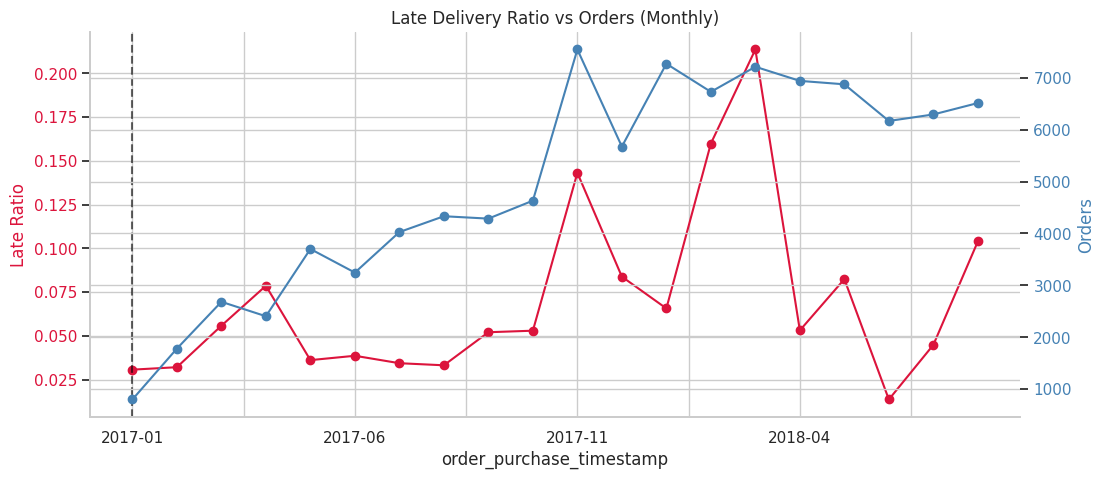

In [8]:
deliv = orders.loc[orders["order_status"].eq("delivered"), [
    "order_id","order_purchase_timestamp",
    "order_delivered_customer_date","order_estimated_delivery_date"
]].dropna()

# Negative gap - delivered after estimate (late)
gap_days = (deliv["order_estimated_delivery_date"] - deliv["order_delivered_customer_date"]).dt.days
deliv = deliv.assign(late=(gap_days < 0).astype(int))

orders_m = (
    orders
    .groupby(orders["order_purchase_timestamp"].dt.to_period("M"))["order_id"]
    .count()
    .rename("orders")
    .to_frame()
)
late_m = (
    deliv
    .groupby(deliv["order_purchase_timestamp"].dt.to_period("M"))["late"]
    .mean()
    .rename("late_ratio")
    .to_frame()
)
joined = orders_m.join(late_m, how="inner")
joined.index = joined.index.astype(str)

fig, ax1 = plt.subplots()
joined["late_ratio"].plot(ax=ax1, color="crimson", marker="o")
ax1.set_ylabel("Late Ratio", color="crimson")
ax1.tick_params(axis='y', labelcolor='crimson')

ax2 = ax1.twinx()
joined["orders"].plot(ax=ax2, color="steelblue", marker="o")
ax2.set_ylabel("Orders", color="steelblue")
ax2.tick_params(axis='y', labelcolor='steelblue')

ax1.set_title("Late Delivery Ratio vs Orders (Monthly)")
ax1.axvline("2017-11", color="black", linestyle="--", alpha=0.6)
plt.show()


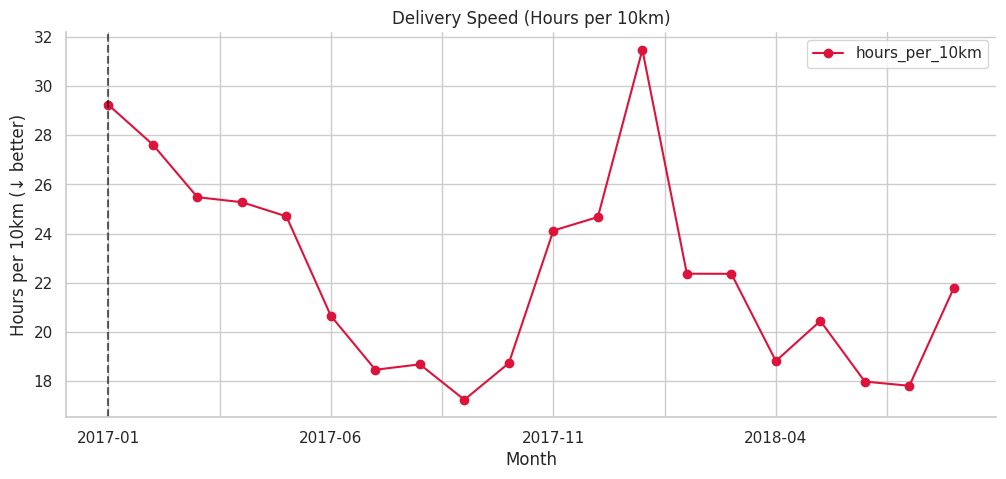

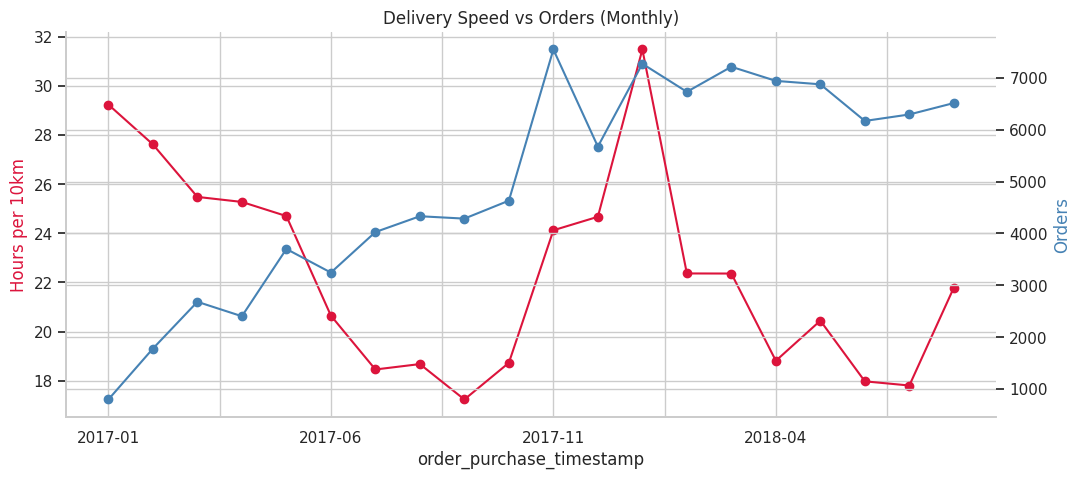

In [9]:
# Join to compute customer–seller distances
delivered_orders = orders.loc[orders["order_status"].eq("delivered"), ["order_id","customer_id","order_purchase_timestamp","order_delivered_customer_date"]].copy()
oi = order_items[["order_id","seller_id","price","freight_value"]].copy()

dist_df = delivered_orders.merge(oi, on="order_id", how="left")\
    .merge(customers[["customer_id","customer_zip_code_prefix"]], on="customer_id", how="left")\
    .rename(columns={"customer_zip_code_prefix":"cust_zip"})\
    .merge(sellers[["seller_id","seller_zip_code_prefix"]], on="seller_id", how="left")\
    .rename(columns={"seller_zip_code_prefix":"seller_zip"})

# Attaching lat/lng for customer and seller using ZIP prefix
dist_df = (dist_df
    .merge(geo[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"]],
           left_on="cust_zip", right_on="geolocation_zip_code_prefix", how="left")
    .rename(columns={"geolocation_lat":"cust_lat","geolocation_lng":"cust_lng"})
    .drop(columns=["geolocation_zip_code_prefix"])
    .merge(geo[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"]],
           left_on="seller_zip", right_on="geolocation_zip_code_prefix", how="left")
    .rename(columns={"geolocation_lat":"seller_lat","geolocation_lng":"seller_lng"})
    .drop(columns=["geolocation_zip_code_prefix"])
)

def haversine_km(row):
    if pd.isna(row["cust_lat"]) or pd.isna(row["cust_lng"]) or pd.isna(row["seller_lat"]) or pd.isna(row["seller_lng"]):
        return np.nan
    clat, clng = radians(row["cust_lat"]), radians(row["cust_lng"])
    slat, slng = radians(row["seller_lat"]), radians(row["seller_lng"])
    dlon, dlat = slng - clng, slat - clat
    a = sin(dlat/2)**2 + cos(clat)*cos(slat)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))
    return 6373.0 * c  # Earth radius ~6373 km

dist_df["distance_km"] = dist_df.apply(haversine_km, axis=1)

# Actual delivery hours
dist_df["actual_hours"] = (dist_df["order_delivered_customer_date"] - dist_df["order_purchase_timestamp"])/np.timedelta64(1,"h")

# Aggregate by order)
by_order = (dist_df.groupby("order_id")
            .agg(distance_km=("distance_km","sum"),
                 actual_hours=("actual_hours","mean"),
                 price=("price","sum"),
                 freight_value=("freight_value","sum"),
                 order_purchase_timestamp=("order_purchase_timestamp","first"))
            .reset_index())

# Remove zero/NaNs and mild outliers by IQR on distance
clean = by_order.dropna(subset=["distance_km","actual_hours"]).copy()
clean = clean[(clean["distance_km"] > 0) & (clean["actual_hours"] > 0)].copy()

q1, q3 = clean["distance_km"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
clean = clean[(clean["distance_km"] >= max(0, lower)) & (clean["distance_km"] <= upper)].copy()

# Hours per 10km
clean["hours_per_10km"] = (clean["actual_hours"] * 10 / clean["distance_km"]).round(2)

monthly_speed = (clean
    .groupby(clean["order_purchase_timestamp"].dt.to_period("M"))["hours_per_10km"]
    .mean()
    .to_frame()
)
monthly_speed.index = monthly_speed.index.astype(str)

ax = monthly_speed.plot(kind="line", marker="o", color="crimson", title="Delivery Speed (Hours per 10km)")
ax.set_xlabel("Month")
ax.set_ylabel("Hours per 10km (↓ better)")
plt.axvline("2017-10", color="black", linestyle="--", alpha=0.6)
plt.show()

# Overlay with orders count
overlay = monthly_speed.join(monthly_orders, how="inner")
fig, ax1 = plt.subplots()
overlay["hours_per_10km"].plot(ax=ax1, color="crimson", marker="o")
ax1.set_ylabel("Hours per 10km", color="crimson")
ax2 = ax1.twinx()
overlay["orders"].plot(ax=ax2, color="steelblue", marker="o")
ax2.set_ylabel("Orders", color="steelblue")
ax1.set_title("Delivery Speed vs Orders (Monthly)")
plt.show()


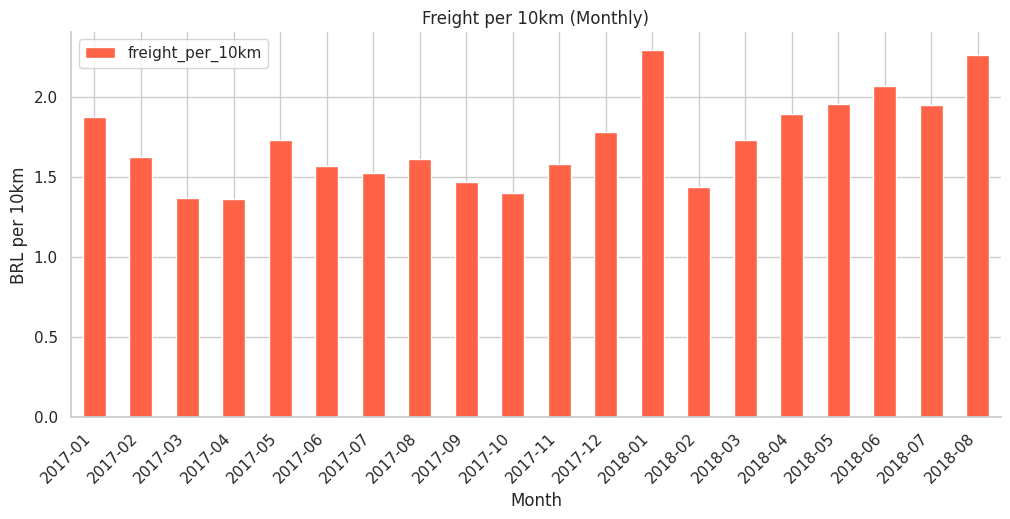

Avg Freight/10km in 2017: 1.57 BRL
Avg Freight/10km in 2018: 1.95 BRL


In [10]:
# Freight per 10km for each order
fr = clean.copy()
fr = fr[(fr["freight_value"] > 0) & (fr["distance_km"] > 0)].copy()
fr["freight_per_10km"] = (fr["freight_value"] / fr["distance_km"]) * 10

fr_m = fr.groupby(fr["order_purchase_timestamp"].dt.to_period("M"))["freight_per_10km"].mean().to_frame()
fr_m.index = fr_m.index.astype(str)

# Show trend + annotate yearly averages
ax = fr_m.plot(kind="bar", color="tomato", title="Freight per 10km (Monthly)")
ax.set_xlabel("Month")
ax.set_ylabel("BRL per 10km")
plt.xticks(rotation=45, ha="right")
plt.show()

avg_2017 = fr_m.loc[[m for m in fr_m.index if m <= "2017-12"], "freight_per_10km"].mean()
avg_2018 = fr_m.loc[[m for m in fr_m.index if m >= "2018-01"], "freight_per_10km"].mean()
print(f"Avg Freight/10km in 2017: {avg_2017:.2f} BRL")
print(f"Avg Freight/10km in 2018: {avg_2018:.2f} BRL")


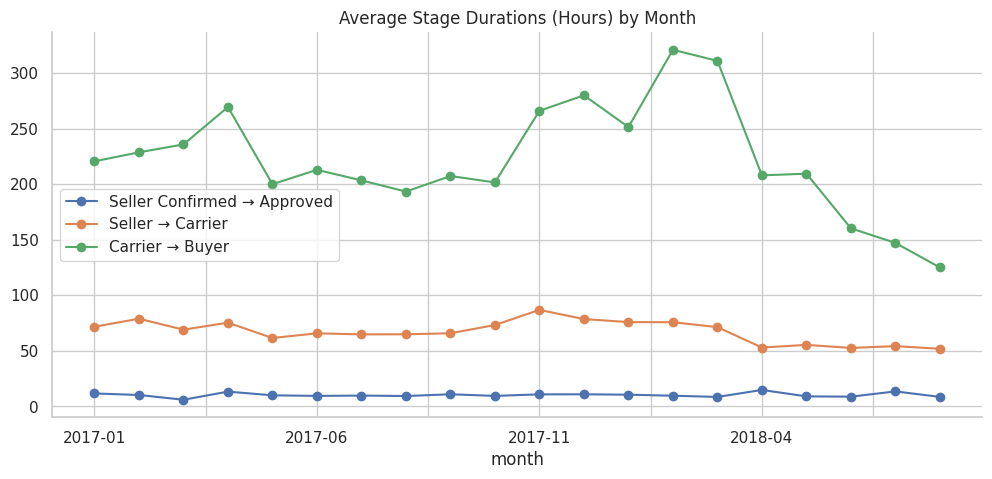

Seller→Carrier accounted for ~27.3% of total time (Oct–Dec 2017).


In [11]:
stage = orders[[
    "order_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date","order_delivered_customer_date"
]].copy()

# Convert to hours
def hours(a, b):
    if pd.isna(a) or pd.isna(b):
        return np.nan
    return (a - b)/np.timedelta64(1,"h")

stage["seller_confirmed_h"] = stage.apply(lambda r: hours(r["order_approved_at"], r["order_purchase_timestamp"]), axis=1)
stage["seller_to_carrier_h"] = stage.apply(lambda r: hours(r["order_delivered_carrier_date"], r["order_approved_at"]), axis=1)
stage["carrier_to_buyer_h"]  = stage.apply(lambda r: hours(r["order_delivered_customer_date"], r["order_delivered_carrier_date"]), axis=1)
stage["month"] = stage["order_purchase_timestamp"].dt.to_period("M").astype(str)

agg = stage.groupby("month")[["seller_confirmed_h","seller_to_carrier_h","carrier_to_buyer_h"]].mean()

ax = agg["seller_confirmed_h"].plot(label="Seller Confirmed → Approved", marker="o")
agg["seller_to_carrier_h"].plot(ax=ax, label="Seller → Carrier", marker="o")
agg["carrier_to_buyer_h"].plot(ax=ax, label="Carrier → Buyer", marker="o")
ax.set_title("Average Stage Durations (Hours) by Month")
ax.legend()
plt.show()

# What share of total delivery time is "seller to carrier" around late-2017?
tmp = clean.merge(
    stage[["order_id","seller_to_carrier_h"]], on="order_id", how="left"
)
tmp["ratio_seller_to_carrier"] = tmp["seller_to_carrier_h"] / tmp["actual_hours"]
period = tmp.loc[(tmp["order_purchase_timestamp"] >= "2017-10-01") &
                 (tmp["order_purchase_timestamp"] <= "2017-12-31"), "ratio_seller_to_carrier"].mean()
print(f"Seller→Carrier accounted for ~{period*100:.1f}% of total time (Oct–Dec 2017).")


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


ml_data = clean[["distance_km","freight_value","price","actual_hours"]].dropna().copy()

X = ml_data[["distance_km","freight_value","price"]]
y = ml_data["actual_hours"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Linear Regression Results")
print(f"RMSE: {rmse:.2f} hours")
print(f"R²: {r2:.3f}")
print("Coefficients:")
for feat, coef in zip(X.columns, lr.coef_):
    print(f"  {feat}: {coef:.4f}")


📊 Linear Regression Results
RMSE: 206.13 hours
R²: 0.107
Coefficients:
  distance_km: 0.1704
  freight_value: 0.3892
  price: 0.0078


In [ ]:
insights = [
    "Order growth shifted in late-2017 alongside a spike in 1–2★ reviews.",
    "Text signals in negative reviews emphasize product quality and delivery issues.",
    "When late-delivery ratio increases, order growth stalls or declines.",
    "Seller→Carrier stage consumed a large share of total lead time during peaks (≈25%).",
    "Despite better speed from ~Mar-2018, rising freight/10km correlates with flat orders."
]
pd.DataFrame({"Key Insights": insights})


,Key Insights
0,Order growth shifted in late-2017 alongside a ...
1,Text signals in negative reviews emphasize pro...
2,"When late-delivery ratio increases, order grow..."
3,Seller→Carrier stage consumed a large share of...
4,"Despite better speed from ~Mar-2018, rising fr..."
